In [1]:
%matplotlib inline

# PyClang boostraping

In [2]:
includedir = "/usr/local/include"

headers = ["clang/AST/ExternalASTSource.h", "clang/AST/DependentDiagnostic.h", "clang/AST/ParentMap.h",
           "clang/AST/DeclGroup.h", "clang/AST/DeclAccessPair.h", "clang/AST/UnresolvedSet.h",
           "clang/AST/DeclarationName.h", "clang/AST/Stmt.h", "clang/AST/Redeclarable.h", "clang/AST/Type.h",
           "clang/AST/SelectorLocationsKind.h", "clang/AST/ExprObjC.h", "clang/AST/OperationKinds.h",
           "clang/AST/DeclObjC.h", "clang/AST/CXXInheritance.h", "clang/AST/CommentLexer.h",
           "clang/AST/ASTTypeTraits.h", "clang/AST/TemplateBase.h", "clang/AST/DeclFriend.h", 
           "clang/AST/OpenMPClause.h", "clang/AST/DeclLookups.h", "clang/AST/StmtVisitor.h",
           "clang/AST/VTableBuilder.h", "clang/AST/ASTUnresolvedSet.h", "clang/AST/GlobalDecl.h",
           "clang/AST/DeclBase.h", "clang/AST/ASTContext.h", "clang/AST/CharUnits.h", "clang/AST/StmtOpenMP.h",
           "clang/AST/TypeLocVisitor.h", "clang/AST/LambdaCapture.h", "clang/AST/CanonicalType.h",
           "clang/AST/PrettyPrinter.h", "clang/AST/CommentCommandTraits.h", "clang/AST/NestedNameSpecifier.h",
           "clang/AST/DeclTemplate.h", "clang/AST/Mangle.h", "clang/AST/StmtIterator.h", "clang/AST/Attr.h",
           "clang/AST/StmtGraphTraits.h", "clang/AST/MangleNumberingContext.h", "clang/AST/StmtCXX.h",
           "clang/AST/CommentSema.h", "clang/AST/RecursiveASTVisitor.h", "clang/AST/ASTConsumer.h",
           "clang/AST/ASTFwd.h", "clang/AST/TypeLoc.h", "clang/AST/CommentDiagnostic.h",
           "clang/AST/VTTBuilder.h", "clang/AST/EvaluatedExprVisitor.h", "clang/AST/CommentParser.h",
           "clang/AST/AttrIterator.h", "clang/AST/DataRecursiveASTVisitor.h", "clang/AST/NSAPI.h",
           "clang/AST/TypeOrdering.h", "clang/AST/TypeVisitor.h", "clang/AST/Decl.h", "clang/AST/ExprCXX.h",
           "clang/AST/CommentVisitor.h", "clang/AST/ASTDiagnostic.h", "clang/AST/AST.h", "clang/AST/ASTLambda.h",
           "clang/AST/StmtObjC.h", "clang/AST/RecordLayout.h", "clang/AST/APValue.h",
           "clang/AST/DeclContextInternals.h", "clang/AST/TemplateName.h", "clang/AST/ASTImporter.h",
           "clang/AST/DeclOpenMP.h", "clang/AST/ASTMutationListener.h", "clang/AST/RawCommentList.h",
           "clang/AST/ASTVector.h", "clang/AST/Comment.h", "clang/AST/DeclCXX.h", "clang/AST/CommentBriefParser.h",
           "clang/AST/Expr.h", "clang/AST/BaseSubobject.h", "clang/AST/DeclVisitor.h", "clang/Frontend/ASTUnit.h",
           "clang/Basic/Specifiers.h"]

headers = [includedir + '/' + header for header in headers]

/usr/lib/pymodules/python2.7/pygraphviz/agraph.py:1281: RuntimeWarning: Warning: k is not a known color.

  warnings.warn("".join(errors),RuntimeWarning)


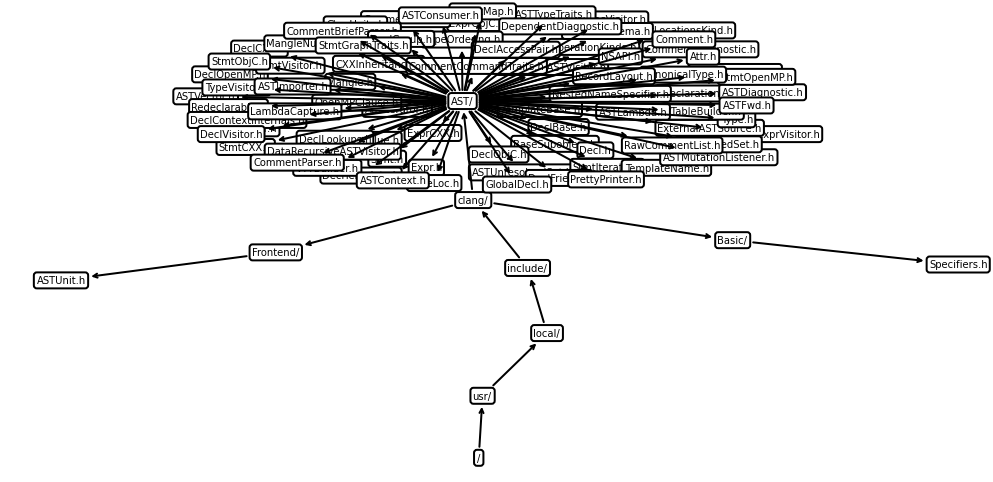

In [3]:
from vplants.autowig.asg import *
asg = AbstractSemanticGraph()
for header in headers:
    filenode = asg.add_file(header, language='c++')
asg

In [4]:
flags = ['-x', 'c++', '-g', '-std=c++11', '-I'+includedir, '-I/usr/local/lib/clang/3.7.0/include',
         '-D__STDC_LIMIT_MACROS', '-D__STDC_CONSTANT_MACROS']
asg[includedir + '/'].parse(flags=flags, libclang=False)

/home/pfernique/Desktop/GitHub/pfernique/autowig/src/vplants/autowig/asg.py:2241: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
  warnings.warn(warning.message + ' for field \'' + spelling + '\'', warning.__class__)
/home/pfernique/Desktop/GitHub/pfernique/autowig/src/vplants/autowig/asg.py:2241: NotImplementedTypeWarning: 'ConstantArray' for field '::pthread_attr_t::__size'
  warnings.warn(warning.message + ' for field \'' + spelling + '\'', warning.__class__)
/home/pfernique/Desktop/GitHub/pfernique/autowig/src/vplants/autowig/asg.py:2241: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6
  warnings.warn(warning.message + ' for field \'' + spelling + '\'', warning.__class__)
/home/pfernique/Desktop/GitHub/pfernique/autowig/src/vplants/autowig/asg.py:2241: NotImplementedTypeWarning: 'ConstantArray' for field '::__size'
  warnings.warn(warning.message + ' for field \'' + spelling + '\'', warning.__class__)
/home/pfernique/De

In [5]:
asg.clean()

Before cleaning: 101402
After  cleaning: 25940


In [6]:
execfile('libclang_cleaning.py')
asg.clean()

Before cleaning: 25940
After  cleaning: 422


In [7]:
from vplants.autowig.boost_python import *
import re

def include(header):
    return '<' + re.sub('(.*)include/(.*)', r'\2', header.globalname) + '>'
    
module = asg.boost_python_module('../src/boost_python/autowig.cpp', '(class |union |struct |enum |)::(.*)', include=include)

In [8]:
module

/home/pfernique/Desktop/GitHub/pfernique/autowig/src/boost_python/autowig.cpp

In [9]:
import re
re.sub('_*', '_', '__a__a__')

'_a_a_'

In [10]:
'a_'.lstrip('_')

'a_'

In [11]:
re.sub('(:|<)+', '_', '::ac::b< :: c ()>')

'_ac_b_ _ c ()>'

In [12]:
re.sub('(\s|\(|\)|>)', '', '::ac::b< :: c (()>')

'::ac::b<::c'